In [175]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Semantic Correspondence with Synthetic 3D Data

In [176]:
import os
import torch
from pytorch3d.implicitron.tools.config import expand_args_fields
from pytorch3d.implicitron.dataset.json_index_dataset import JsonIndexDataset
from pytorch3d.implicitron.dataset.visualize import get_implicitron_sequence_pointcloud
from pytorch3d.implicitron.tools.point_cloud_utils import render_point_cloud_pytorch3d

# Setup dataset root and paths
_CO3DV2_DATASET_ROOT = "/export/group/datasets/co3d"
category = "car"
dataset_root = _CO3DV2_DATASET_ROOT
print(os.listdir(dataset_root))
print(len(['teddybear', 'carrot', 'toytrain', 'kite', 'wineglass', 'plant', 'couch', 'parkingmeter', 'mouse', 'broccoli', 'toytruck', 'toybus', 'bench', 'laptop', 'remote', 'hairdryer', 'donut', 'handbag', 'toaster', 'cake', 'orange', 'cup', 'toyplane', 'backpack', 'sandwich', 'vase', 'chair', 'bottle', 'car', 'hotdog', 'microwave', 'tv', 'stopsign', 'cellphone', 'hydrant', 'baseballglove', 'apple', 'motorcycle', 'keyboard', 'bowl', 'banana', 'suitcase', 'book', 'skateboard', 'pizza', 'ball', 'frisbee', 'toilet', 'bicycle', 'baseballbat', 'umbrella']))
frame_file = os.path.join(dataset_root, category, "frame_annotations.jgz")
sequence_file = os.path.join(dataset_root, category, "sequence_annotations.jgz")
image_size = 256

# Initialize dataset
expand_args_fields(JsonIndexDataset)
dataset = JsonIndexDataset(
    frame_annotations_file=frame_file,
    sequence_annotations_file=sequence_file,
    dataset_root=dataset_root,
    image_height=image_size,
    image_width=image_size,
    load_point_clouds=True,
    mask_images=False,
    load_images=True,
    load_masks=True,
    mask_depths=True,
    box_crop=False,
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['teddybear', 'carrot', 'toytrain', 'kite', 'wineglass', 'plant', 'couch', 'parkingmeter', 'mouse', 'broccoli', 'toytruck', 'toybus', 'category_to_subset_name_list.json', 'bench', 'laptop', 'remote', 'hairdryer', 'donut', 'co3d', 'handbag', 'toaster', 'cake', 'orange', 'cup', 'toyplane', 'backpack', 'sandwich', 'vase', 'chair', 'bottle', 'car', 'hotdog', 'microwave', 'tv', 'stopsign', 'cellphone', '_in_progress', 'hydrant', 'baseballglove', 'apple', 'motorcycle', 'keyboard', 'bowl', 'banana', 'suitcase', 'book', 'skateboard', 'pizza', 'ball', 'frisbee', 'toilet', 'bicycle', 'baseballbat', 'umbrella']
51


In [177]:
import random
random.seed(43)

In [178]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

(-0.5, 255.5, 255.5, -0.5)

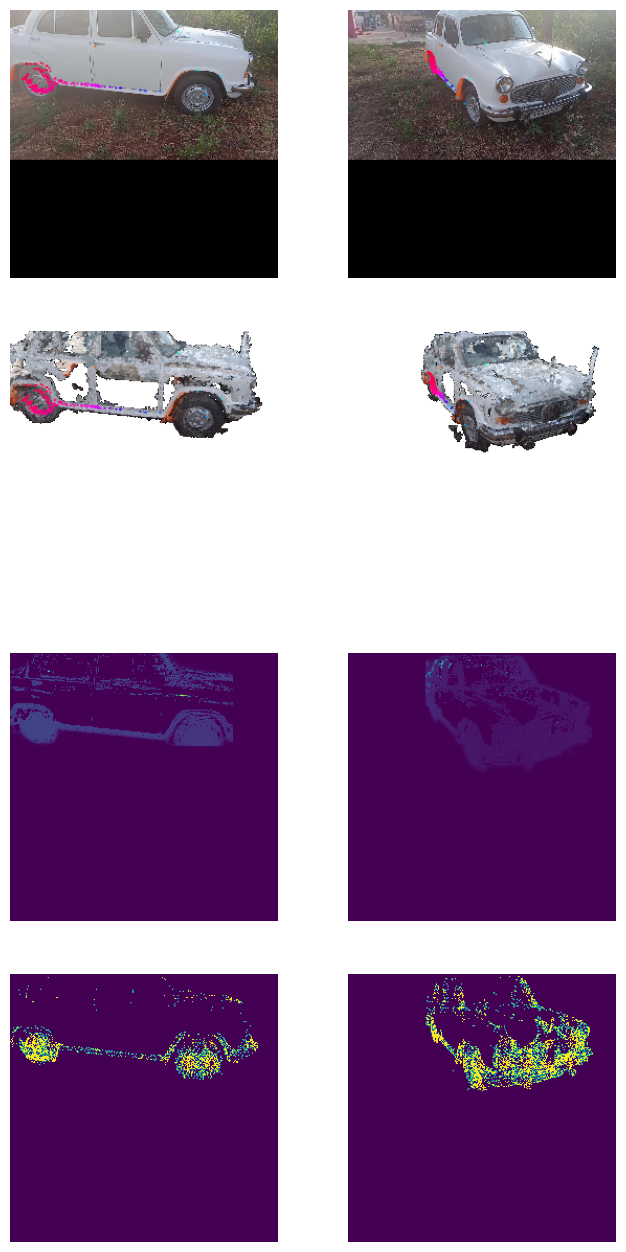

In [216]:
from matplotlib import pyplot as plt
from pytorch3d.renderer.cameras import get_screen_to_ndc_transform

# 1. Sample random sequence from dataset
random_index = random.randint(0, len(dataset.seq_annots.keys()) - 1)
sequence_name = list(dataset.seq_annots.keys())[random_index]

point_cloud, sequence_frame_data = get_implicitron_sequence_pointcloud(
    dataset,
    sequence_name=sequence_name,
    mask_points=True,
    max_frames=2,
    num_workers=1,
    load_dataset_point_cloud=True,
)
point_cloud = point_cloud.to(device)

# 2. Sample two random frames from the sequence which are not the same
frame_indices = range(len(sequence_frame_data.frame_number))
source_idx, target_idx = frame_indices
source_image = sequence_frame_data.image_rgb[source_idx]
source_camera = sequence_frame_data.camera.to(device)[source_idx]
target_image = sequence_frame_data.image_rgb[target_idx]
target_camera = sequence_frame_data.camera.to(device)[target_idx]
source_depth_mask = sequence_frame_data.depth_mask[source_idx].squeeze(0).cuda()
target_depth_mask = sequence_frame_data.depth_mask[target_idx].squeeze(0).cuda()
source_depth = sequence_frame_data.depth_map[source_idx].squeeze(0).cuda()
target_depth = sequence_frame_data.depth_map[target_idx].squeeze(0).cuda()

# 4. Render source and target images
source_image_render, _, _ = render_point_cloud_pytorch3d(
    source_camera,
    point_cloud,
    render_size=(image_size, image_size),
    point_radius=1e-2,
    topk=10,
    bg_color=1.0,
    bin_size=0,
)
source_rendered_image = source_image_render[0].clamp(0.0, 1.0).cpu()

target_image_render, _, _ = render_point_cloud_pytorch3d(
    target_camera,
    point_cloud,
    render_size=(image_size, image_size),
    point_radius=1e-2,
    topk=10,
    bg_color=1.0,
    bin_size=0,
)
target_rendered_image = target_image_render[0].clamp(0.0, 1.0).cpu()

def get_nonzero_points(depth, mask):
    nz_indices = (mask > 0).nonzero()
    depth_values = depth[nz_indices[:, 0], nz_indices[:, 1]]
    return torch.stack((nz_indices[:, 1], nz_indices[:, 0], depth_values), dim=1) # X, Y, Z in screen space

# 5. Determine corresponding point on target image using point cloud and camera info
source_points_3d = get_nonzero_points(source_depth, source_depth_mask) # X, Y, Z in screen space
source_points_3d = get_screen_to_ndc_transform(source_camera, image_size=(image_size, image_size), with_xyflip=True).transform_points(source_points_3d) # X, Y, Z in NDC
source_points_3d = source_camera.unproject_points(source_points_3d, world_coordinates=True, from_ndc=True) # X, Y, Z in world space

source_points = source_camera.transform_points_screen(source_points_3d, image_size=(image_size, image_size)) # Y, X, Z in screen space
source_points = source_points[:, [1, 0]].long().clamp(0, image_size - 1)

target_points_3d = target_camera.transform_points_screen(source_points_3d, image_size=(image_size, image_size)) # Y, X, Z in screen space
target_points = target_points_3d[:, [1, 0]].long().clamp(0, image_size - 1)

# Remove points that are outside of the image
valid_indices = (target_points[:, 0] >= 0) & (target_points[:, 0] < image_size) & (target_points[:, 1] >= 0) & (target_points[:, 1] < image_size)
source_points = source_points[valid_indices]
target_points = target_points[valid_indices]

# Mask out points that are not visible in target image by comparing depth values of rendered target depth and correspondence target depth
depth_values = target_depth[target_points[:, 0], target_points[:, 1]]
temp_points = torch.stack((target_points[:, 0], target_points[:, 1], depth_values), dim=1)
temp_points = get_screen_to_ndc_transform(target_camera, image_size=(image_size, image_size), with_xyflip=True).transform_points(temp_points[:, [1, 0, 2]])
temp_points = target_camera.unproject_points(temp_points, world_coordinates=True, from_ndc=True)
temp_points = target_camera.transform_points_screen(temp_points, image_size=(image_size, image_size))
depth_values_t = target_points_3d[:, 2]
depth_values = temp_points[:, 2]
target_indices = torch.abs(depth_values_t - depth_values) < 0.01 # thickness threshold

target_indices2 = target_depth_mask[target_points[:, 0], target_points[:, 1]] > .5
target_indices = target_indices2 & target_indices

target_points = target_points[target_indices]
source_points = source_points[target_indices]

# rainbow color map
grid_center = torch.max(source_points, dim=0)[0] / 2
angles = torch.arctan2(source_points[:, 0] - grid_center[0], source_points[:, 1] - grid_center[1])
normalized_angles = (angles + torch.pi) / (2 * torch.pi)
colors = plt.get_cmap('hsv')(normalized_angles.cpu())

fig, ax = plt.subplots(4, 2, figsize=(8, 16))
ax[0, 0].imshow(source_image.permute(1, 2, 0))
ax[0, 0].scatter(source_points[:, 1].cpu(), source_points[:, 0].cpu(), c=colors, s=1, alpha=[0.5] * len(source_points), )
ax[0, 0].axis("off")
ax[0, 1].imshow(target_image.permute(1, 2, 0))
ax[0, 1].scatter(target_points[:, 1].cpu(), target_points[:, 0].cpu(), c=colors, s=1, alpha=[0.5] * len(target_points))
ax[0, 1].axis("off")
ax[1, 0].imshow(source_rendered_image.permute(1, 2, 0))
ax[1, 0].scatter(source_points[:, 1].cpu(), source_points[:, 0].cpu(), c=colors, s=1, alpha=[0.5] * len(source_points))
ax[1, 0].axis("off")
ax[1, 1].imshow(target_rendered_image.permute(1, 2, 0))
ax[1, 1].scatter(target_points[:, 1].cpu(), target_points[:, 0].cpu(), c=colors, s=1, alpha=[0.5] * len(target_points))
ax[1, 1].axis("off")
ax[2, 1].imshow(target_depth.squeeze(0).cpu())
ax[2, 1].axis("off")
ax[2, 0].imshow(source_depth.squeeze(0).cpu())
ax[2, 0].axis("off")
ax[3, 0].imshow(source_depth_mask.cpu())
ax[3, 0].axis("off")
ax[3, 1].imshow(target_depth_mask.cpu())
ax[3, 1].axis("off")